In [1]:
import os
os.chdir("/home/jennifer.badolato/watttime-python-client-aer-algo")

import math
import numpy as np
import pandas as pd
import datetime
import random
import pytz
from datetime import datetime, timedelta
import random
from watttime import WattTimeMyAccess, WattTimeHistorical, WattTimeForecast, WattTimeMaps
import os
import optimizer.dataset as od
from evaluation.config import MOER_REGION_LIST
import evaluation.eval_framework as evu
import optimizer.s3 as s3u

import seaborn as sns
import matplotlib.pyplot as plt

import watttime.shared_anniez.alg.optCharger as optC
import watttime.shared_anniez.alg.moer as Moer

In [2]:
region = "PJM_NJ"
username = os.getenv("WATTTIME_USER")
password = os.getenv("WATTTIME_PASSWORD")

actual_data = WattTimeHistorical(username, password)
hist_data = WattTimeForecast(username, password)

s3 = s3u.s3_utils()
key = '20240701_1k_synth_users.csv'
generated_data = s3.load_csvdataframe(file=key)

# Function

In [3]:
def intervalize_power_rate(kW_value: float, convert_to_MW = True):
    five_min_rate = kW_value / 12
    if convert_to_MW:
        five_min_rate = five_min_rate / 1000
    else:
        five_min_rate
    return five_min_rate

def sum_moer_actuals(moer_data, MWh_fraction,plug_in_time, number_conseq_intervals):
    index_lower_limit = moer_data[moer_data.point_time >= plug_in_time].index[0]
    index_upper_limit = index_lower_limit + int(number_conseq_intervals)
    return sum(
        moer_data[index_lower_limit: index_upper_limit]["value"] * MWh_fraction
        )

def calculate_five_minute_intervals(start_date, end_date):
    """
    Calculate the number of 5 minute intervals between two datetime objects.

    Parameters:
    start_date (datetime): The start date as a datetime object.
    end_date (datetime): The end date as a datetime object.

    Returns:
    int: The number of 5 minute intervals between the two dates.
    """
    # Calculate the difference in seconds between the two dates
    delta_seconds = (end_date - start_date).total_seconds()

    # Calculate the number of 5 minute intervals
    five_minute_intervals = delta_seconds / (5 * 60)

    return math.ceil(five_minute_intervals)

# Get per-row historical fcsts at 'plug in time'
def get_historical_fcst_data(
    plug_in_time, 
    horizon,
    region
    ):
    plug_in_time = pd.Timestamp(plug_in_time)
    horizon = math.ceil(horizon / 12)
    return hist_data.get_historical_forecast_pandas(
        start=plug_in_time - pd.Timedelta(minutes=5), 
        end=plug_in_time, 
        horizon_hours=horizon,
        region=region
    )

## New Variables

In [6]:
generated_data["MWh_fraction"] = generated_data["power_output_rate"].apply(intervalize_power_rate)
generated_data["number_intervals_drawing_power"] = generated_data.charged_kWh_actual / generated_data.power_output_rate * 60 / 5

generated_data["plug_in_time" ]= pd.to_datetime(generated_data["plug_in_time"])
generated_data["unplug_time" ]= pd.to_datetime(generated_data["unplug_time"])

generated_data["charge_MWh_needed"] = generated_data["total_capacity"] * (0.95 - generated_data["initial_charge"]) / 1000

generated_data["total_intervals_plugged_in"] = generated_data["length_plugged_in"] / 300 # number of seconds in 5 minutes

## MOER no optimization

In [19]:
moer_actuals = actual_data.get_historical_pandas(
    start=generated_data.plug_in_time.min(),
    end=generated_data.unplug_time.max(),
    region=region
)

In [20]:
generated_data["moer_actuals"] = generated_data.apply(
    lambda x: sum_moer_actuals(
        moer_actuals,
        x.MWh_fraction,
        x.plug_in_time,
        x.number_intervals_drawing_power
        ), axis=1
        )

## Compare with Annie Greedy Fit

In [4]:
# to avoid the assert error if passing the plug out time without meeting 95%
generated_data = generated_data[generated_data.final_perc_charged == 0.95]

In [10]:
### just one example

row = 3

plug_in_time = generated_data["plug_in_time"][row]
horizon = generated_data["total_intervals_plugged_in"][row]
total_time = generated_data["total_intervals_plugged_in"][row]
charge_rate_per_window = generated_data["MWh_fraction"][row]
charge_needed = generated_data["charge_MWh_needed"][row]


In [16]:
int(total_time)

44

In [13]:
df_fcst.shape

(48, 3)

In [11]:
df_fcst = get_historical_fcst_data(
    plug_in_time = plug_in_time,
    horizon = horizon,
    region = region
)

In [22]:
moer_greedy = Moer.Moer(df_fcst["value"])
charger_greedy = optC.OptCharger(charge_rate_per_window) # charge rate converted to MWh

charger_greedy.fit(
        totalCharge=charge_needed, # also currently an int value
        totalTime = math.ceil(total_time),
        moer=moer_greedy,
        asap=True
    )

Greedy fit!
[0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0, 0, 0] 45


In [23]:
charger_greedy.get_total_cost()

25.067179499999998

In [24]:
# discrepancy
generated_data.moer_actuals[row]

23.191459500000004

## Simple fit

In [25]:
moer_simple = Moer.Moer(df_fcst["value"], isDiagonal=False)
charger_simple = optC.OptCharger(charge_rate_per_window)

charger_simple.fit(
        totalCharge=charge_needed, # also currently an int value
        totalTime = math.ceil(total_time),
        moer=moer_simple,
        asap=False
    )

Simplified fit!


In [26]:
charger_simple.get_charging_cost()

25.046843250000002

<Axes: xlabel='value', ylabel='Count'>

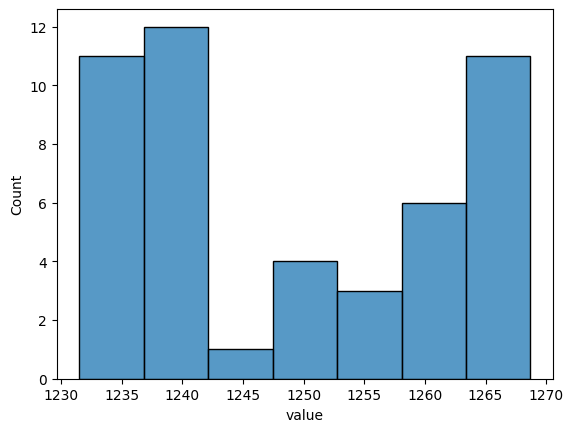

In [27]:
sns.histplot(df_fcst["value"])

## Apply Across Frame

In [28]:
# smaller example
data_50_examples = generated_data.head(50).copy(deep=True)

In [47]:
# Set up OptCharger based on moer fcsts and get info on projected schedule
def get_schedule_and_cost(
    charge_rate_per_window, 
    charge_needed, 
    total_time_horizon, 
    moer_data,
    asap = False
    ):
    charger = optC.OptCharger(charge_rate_per_window) # charge rate needs to be an int
    moer = Moer.Moer(moer_data['value'])

    charger.fit(
        totalCharge=charge_needed, # also currently an int value
        totalTime = total_time_horizon,
        moer=moer,
        asap=asap
    )
    return charger

In [29]:
data_50_examples['moer_data'] = data_50_examples.apply(
    lambda x: get_historical_fcst_data(
    x.plug_in_time, 
    x.total_intervals_plugged_in,
    region = region
    ), axis = 1
)


 Warnings Returned: {'region': 'PJM_NJ', 'signal_type': 'co2_moer', 'horizon_hours': 10, 'start': Timestamp('2024-02-15 20:09:49+0000', tz='UTC'), 'end': Timestamp('2024-02-15 20:14:49+0000', tz='UTC')} {'data_point_period_seconds': 300, 'region': 'PJM_NJ', 'signal_type': 'co2_moer', 'units': 'lbs_co2_per_mwh', 'warnings': [{'type': 'MISSING_DATA', 'message': 'You made a valid request, but we have some datapoints missing. This can happen for a variety of reasons. If the data is less than a week old, we will most likely fill in this data soon. If it is older than that, we are missing enough important grid data during this time period that we are not able to generate an accurate estimate'}], 'model': {'date': '2023-03-01'}, 'generated_at_period_seconds': 300}


In [30]:
key = '20240701_1k_synth_users_with_moer_data.csv'
s3.store_csvdataframe(dataframe=data_50_examples, file=key)

Successful S3 put_object response. Status - 200


In [31]:
data_50_examples_trial = data_50_examples.head(5)

In [40]:
data_50_examples_trial.reset_index(drop=True, inplace=True)

In [44]:
data_50_examples_trial.total_intervals_plugged_in = data_50_examples_trial.total_intervals_plugged_in.apply(lambda x: math.ceil(x))

/tmp/ipykernel_1090212/1566194440.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_50_examples_trial.total_intervals_plugged_in = data_50_examples_trial.total_intervals_plugged_in.apply(lambda x: math.ceil(x))


In [45]:
data_50_examples_trial['charger']= data_50_examples_trial.apply(
    lambda x: get_schedule_and_cost(
        x.MWh_fraction,
        x.charge_MWh_needed,
        x.total_intervals_plugged_in,
        x.moer_data
        ), 
        axis = 1
        )

data_50_examples_trial['charging_schedule'] = data_50_examples_trial['charger'].apply(lambda x: x.get_schedule())
data_50_examples_trial['projected_charging_cost_to_full'] = data_50_examples_trial['charger'].apply(lambda  x: x.get_total_cost())

Simplified fit!
Simplified fit!
Simplified fit!
Simplified fit!
Simplified fit!


/tmp/ipykernel_1090212/1666561353.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_50_examples_trial['charger']= data_50_examples_trial.apply(
/tmp/ipykernel_1090212/1666561353.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_50_examples_trial['charging_schedule'] = data_50_examples_trial['charger'].apply(lambda x: x.get_schedule())
/tmp/ipykernel_1090212/1666561353.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

In [ ]:
data_50_examples_trial['charger']= data_50_examples_trial.apply(
    lambda x: get_schedule_and_cost(
        x.MWh_fraction,
        x.charge_MWh_needed,
        x.total_intervals_plugged_in,
        x.moer_data
        ), 
        axis = 1
        )

data_50_examples_trial['charging_schedule'] = data_50_examples_trial['charger'].apply(lambda x: x.get_schedule())
data_50_examples_trial['projected_charging_cost_to_full'] = data_50_examples_trial['charger'].apply(lambda  x: x.get_total_cost())

In [48]:
data_50_examples_trial['charger_greedy']= data_50_examples_trial.apply(
    lambda x: get_schedule_and_cost(
        x.MWh_fraction,
        x.charge_MWh_needed,
        x.total_intervals_plugged_in,
        x.moer_data,
        asap = True
        ), 
        axis = 1
        )

Greedy fit!
[0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 108
Greedy fit!
[0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.0004785, 0.000

/tmp/ipykernel_1090212/2713600659.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_50_examples_trial['charger_greedy']= data_50_examples_trial.apply(


In [49]:
data_50_examples_trial['greedy_cost'] = data_50_examples_trial['charger_greedy'].apply(lambda  x: x.get_total_cost())

/tmp/ipykernel_1090212/3160133362.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_50_examples_trial['greedy_cost'] = data_50_examples_trial['charger_greedy'].apply(lambda  x: x.get_total_cost())


In [51]:
data_50_examples_trial.T

,0,1,2,3,4
index,0,3,6,8,9
distinct_dates,2024-02-01 00:00:00+00:00,2024-02-04 00:00:00+00:00,2024-02-07 00:00:00+00:00,2024-02-09 00:00:00+00:00,2024-02-10 00:00:00+00:00
user_type,r5.742_tc55_avglc21216_sdlc7829,r5.742_tc55_avglc21216_sdlc7829,r5.742_tc55_avglc21216_sdlc7829,r5.742_tc55_avglc21216_sdlc7829,r5.742_tc55_avglc21216_sdlc7829
plug_in_time,2024-02-01 17:46:20+00:00,2024-02-04 19:20:24+00:00,2024-02-07 18:13:36+00:00,2024-02-09 20:53:20+00:00,2024-02-10 17:12:52+00:00
unplug_time,2024-02-02 02:44:00.359457+00:00,2024-02-04 23:03:20.042497+00:00,2024-02-08 00:54:40.309282+00:00,2024-02-10 03:39:04.627557+00:00,2024-02-11 00:34:57.961801+00:00
initial_charge,0.393136,0.585984,0.384204,0.433035,0.428565
total_seconds_to_95,19202.190817,12552.267144,19510.207175,17826.395873,17980.500701
full_charge_time,2024-02-01 23:06:22.190816627+00:00,2024-02-04 22:49:36.267144481+00:00,2024-02-07 23:38:46.207175220+00:00,2024-02-10 01:50:26.395873246+00:00,2024-02-10 22:12:32.500701037+00:00
length_plugged_in,32260.359457,13376.042497,24064.309282,24344.627557,26525.961801
charged_kWh_actual,30.627494,20.020866,31.11878,28.433101,28.678899


In [52]:
39.981546 - 39.513764

0.4677819999999997